In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from collections import deque

import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter

import tensorflow as tf
from tensorflow.python import debug as tf_debug
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import Binarizer

import datetime as DT

In [2]:
%load_ext autoreload
%autoreload 2

In [8]:
df = pd.read_csv('./dump.csv')

ValueError: Item wrong length 243 instead of 32.

In [3]:
%aimport DQN
%aimport Memory
%aimport SumTree

from DQN import DeepQNetwork
from Memory import Memory
from SumTree import SumTree
from Portfolio import Portfolio

In [4]:
# train = pd.read_csv('./data/quote_processed.csv')
train = pd.read_csv('./data/quote_M5.csv')

In [5]:
train.head()

,Timestamp,Date,Time,Close,Spread,SpanWidth,SummerTime,WinterTime,HK,EU,...,LogReturn_H4_1,LogReturn_H4_5,LogReturn_H4_10,LogReturn_H4_20,LogReturn_H4_50,LogReturn_D1_1,LogReturn_D1_5,LogReturn_D1_10,LogReturn_D1_20,LogReturn_D1_50
0,1361923200,2013-02-27,0:00:00,1.306160,1.6,4.55,0,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1361923500,2013-02-27,0:05:00,1.305690,1.6,6.95,0,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1361923800,2013-02-27,0:10:00,1.305675,1.3,5.35,0,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1361924100,2013-02-27,0:15:00,1.305375,1.7,3.65,0,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1361924400,2013-02-27,0:20:00,1.305490,1.2,2.30,0,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
train.shape

(326220, 123)

In [7]:
X_train = train[10000:50000]
X_test = train[50000:70000]

In [8]:
X_train.head()

,Timestamp,Date,Time,Close,Spread,SpanWidth,SummerTime,WinterTime,HK,EU,...,LogReturn_H4_1,LogReturn_H4_5,LogReturn_H4_10,LogReturn_H4_20,LogReturn_H4_50,LogReturn_D1_1,LogReturn_D1_5,LogReturn_D1_10,LogReturn_D1_20,LogReturn_D1_50
10000,1366132800,2013-04-16,17:20:00,1.317850,3.2,4.10,1,0,0,0,...,0.313429,0.97657,0.793261,0.443649,1.869585,-0.103668,-0.202645,1.662965,0.583459,-0.592251
10001,1366133100,2013-04-16,17:25:00,1.317850,3.0,1.05,1,0,0,0,...,0.313429,0.97657,0.793261,0.443649,1.869585,-0.103668,-0.202645,1.662965,0.583459,-0.592251
10002,1366133400,2013-04-16,17:30:00,1.317895,4.7,3.05,1,0,0,0,...,0.313429,0.97657,0.793261,0.443649,1.869585,-0.103668,-0.202645,1.662965,0.583459,-0.592251
10003,1366133700,2013-04-16,17:35:00,1.318040,5.6,6.75,1,0,0,0,...,0.313429,0.97657,0.793261,0.443649,1.869585,-0.103668,-0.202645,1.662965,0.583459,-0.592251
10004,1366134000,2013-04-16,17:40:00,1.317805,2.3,4.70,1,0,0,0,...,0.313429,0.97657,0.793261,0.443649,1.869585,-0.103668,-0.202645,1.662965,0.583459,-0.592251


In [9]:
X_train = X_train.drop(['Timestamp', 'Date', 'Time'], axis=1)
X_test = X_test.drop(['Timestamp', 'Date', 'Time'], axis=1)

In [10]:
X_train.describe()

,Close,Spread,SpanWidth,SummerTime,WinterTime,HK,EU,US,Sun,Mon,...,LogReturn_H4_1,LogReturn_H4_5,LogReturn_H4_10,LogReturn_H4_20,LogReturn_H4_50,LogReturn_D1_1,LogReturn_D1_5,LogReturn_D1_10,LogReturn_D1_20,LogReturn_D1_50
count,40000.000000,40000.000000,40000.000000,40000.0,40000.0,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,...,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,1.323633,1.420702,4.609154,1.0,0.0,0.375300,0.208500,0.416200,0.058800,0.198800,...,0.004598,0.033476,0.066204,0.123328,0.292876,0.050408,0.145417,0.295501,0.626481,1.055266
std,0.023259,0.672080,3.960181,0.0,0.0,0.484206,0.406241,0.492934,0.235253,0.399102,...,0.192573,0.418245,0.554667,0.754538,1.263919,0.447421,0.880154,1.279379,1.647575,1.190325
min,1.276520,0.600000,0.050000,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.973377,-1.442080,-1.578852,-2.338676,-2.955623,-1.007617,-2.097150,-2.781643,-4.159987,-2.575283
25%,1.306185,1.100000,2.300000,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.067289,-0.195802,-0.281317,-0.366297,-0.505907,-0.170857,-0.410855,-0.505393,-0.418355,0.184940
50%,1.322582,1.300000,3.650000,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.004248,0.029479,0.050524,0.188927,0.407157,0.024328,0.159074,0.430950,0.806903,1.358712
75%,1.336725,1.400000,5.700000,1.0,0.0,1.000000,0.000000,1.000000,0.000000,0.000000,...,0.077078,0.254936,0.386984,0.617164,1.128364,0.272948,0.749758,1.075981,1.773972,1.900770
max,1.382765,15.000000,99.800000,1.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.798545,2.611052,2.494338,2.342572,2.942977,2.744000,2.252085,2.909083,3.802452,4.195085


In [26]:
n_actions = 3
n_features = X_train.shape[1]
MEMORY_SIZE = 2000
e_greedy_increment = 0.0001
# batch_size = 64
# total_batch = int(X_train.shape[0] / batch_size)  
# batches = np.array_split(X_train.values, total_batch)

In [27]:
tf.reset_default_graph()
# sess = tf.Session()
oracle = DeepQNetwork(n_actions=n_actions, n_features=n_features, memory_size=MEMORY_SIZE,
        e_greedy_increment=e_greedy_increment, sess=None, dueling=True, output_graph=False, prioritized=True)
# oracle.load()
# sess.run(tf.global_variables_initializer())

In [36]:
epoches = 200
display_interval = 240

In [29]:
# price = tf.placeholder(tf.float32, shape=[None, 1], name='price')
# price_next = tf.placeholder(tf.float32, shape=[None, 1], name='price_next')
# balance = tf.placeholder(tf.float32, shape=[None, 1], name='balance')
# position = tf.placeholder(tf.float32, shape=[None, 1], name='position')
# action = tf.placeholder(tf.int32, shape=[None, 1], name='action')

# reward, balance, position = getReward(price, price_next, action, balance, position)
step = 0

In [30]:
history = deque()
length = len(X_train)

In [31]:
batch_size = 1000

In [37]:
for epoch in range(epoches):
    
    print('Epoch: {}'.format(epoch))
#     account = {
#         'balance': 1000,
#         'position': 0
#     }
    goldkeeper = Portfolio(1000, 0, 0)
    
#     history.append([])
    price_prev = 0
    n_trades = 0
    
    total_batch = int(X_train.shape[0] / batch_size)        
    X_batches = np.array_split(X_train.values, total_batch)
    
    for b in range(total_batch):
    
        dataset = X_batches[b]
        observation = dataset[0]

        for i in range(len(dataset) - 1):

            action = oracle.choose_action(observation)
    #         print ('Action for {}: {}'.format(i, action))

            if (action != 0):
                n_trades += 1

    #         reward, account = getReward(observation[0], price_prev, action, account['balance'], account['position'])
            if action == 1:
                direction = 1
            elif action == 2:
                direction = -1
            elif action == 0:
                direction = None

            position = goldkeeper.cal_position_size(direction) if direction is not None else 0
            reward = goldkeeper.get_reward(observation[0], price_prev, action, position)
    #         history[epoch].append(action)

            observation_ = dataset[i + 1]
            oracle.store_transition(observation, action, reward, observation_)

            price_prev = observation[0]
            observation = observation_               

            if (step > 2000 and step % 200 == 0):
                oracle.learn()            

            if (i % display_interval == 0):
                print ('Batch: {}, Balance: {}, Position: {}, Trades: {}'.format(b, int(goldkeeper.balance), goldkeeper.position, n_trades))
                goldkeeper.print_stat()

            step += 1        

    #     oracle.finish_episode(epoch, goldkeeper.balance)

Epoch: 0
Initial balance: 1000, Position: 0, Order Price: 0
Batch: 0, Balance: 1000, Position: 5000, Trades: 1

Batch: 0, Balance: 986, Position: 4931, Trades: 170

Batch: 0, Balance: 993, Position: 4969, Trades: 330

Batch: 0, Balance: 1003, Position: 5019, Trades: 500

Batch: 0, Balance: 980, Position: -4904, Trades: 666

Batch: 1, Balance: 988, Position: 0, Trades: 695

Batch: 1, Balance: 1013, Position: -5069, Trades: 874

Batch: 1, Balance: 1036, Position: 0, Trades: 1049

Batch: 1, Balance: 998, Position: -4990, Trades: 1216

Batch: 1, Balance: 1018, Position: 5093, Trades: 1389

Batch: 2, Balance: 1019, Position: 5095, Trades: 1419

Batch: 2, Balance: 1052, Position: 5260, Trades: 1586

Batch: 2, Balance: 1087, Position: 5439, Trades: 1744

Batch: 2, Balance: 1089, Position: 0, Trades: 1901

Batch: 2, Balance: 1097, Position: 5487, Trades: 2066

Batch: 3, Balance: 1103, Position: 5515, Trades: 2094

Batch: 3, Balance: 1082, Position: 5410, Trades: 2273

Batch: 3, Balance: 1036, 

Batch: 30, Balance: 999, Position: 0, Trades: 20354

Batch: 30, Balance: 982, Position: -4911, Trades: 20527

Batch: 30, Balance: 963, Position: -4818, Trades: 20680

Batch: 30, Balance: 979, Position: 0, Trades: 20843

Batch: 31, Balance: 976, Position: -4880, Trades: 20865

Batch: 31, Balance: 995, Position: 4976, Trades: 21030

Batch: 31, Balance: 1002, Position: 5014, Trades: 21208

Batch: 31, Balance: 1027, Position: 0, Trades: 21369

Batch: 31, Balance: 1094, Position: -5470, Trades: 21526

Batch: 32, Balance: 1087, Position: -5437, Trades: 21557

Batch: 32, Balance: 1100, Position: -5504, Trades: 21721

Batch: 32, Balance: 1090, Position: 0, Trades: 21862

Batch: 32, Balance: 1105, Position: -5527, Trades: 22028

Batch: 32, Balance: 1101, Position: 5505, Trades: 22184

Batch: 33, Balance: 1083, Position: 0, Trades: 22211

Batch: 33, Balance: 1107, Position: 0, Trades: 22383

Batch: 33, Balance: 1112, Position: -5561, Trades: 22563

Batch: 33, Balance: 1084, Position: 0, Trades: 

Batch: 20, Balance: 1037, Position: -5188, Trades: 14237

Batch: 21, Balance: 1036, Position: 0, Trades: 14263

Batch: 21, Balance: 1044, Position: -5220, Trades: 14412

Batch: 21, Balance: 1040, Position: 5202, Trades: 14560

Batch: 21, Balance: 1036, Position: -5181, Trades: 14711

Batch: 21, Balance: 1037, Position: 5186, Trades: 14869

Batch: 22, Balance: 1038, Position: 0, Trades: 14895

Batch: 22, Balance: 1017, Position: 5086, Trades: 15035

Batch: 22, Balance: 1060, Position: -5300, Trades: 15206

Batch: 22, Balance: 1091, Position: 5458, Trades: 15331

Batch: 22, Balance: 1090, Position: 5450, Trades: 15489

Batch: 23, Balance: 1081, Position: -5406, Trades: 15517

Batch: 23, Balance: 1060, Position: 0, Trades: 15672

Batch: 23, Balance: 1063, Position: 5319, Trades: 15828

Batch: 23, Balance: 1062, Position: 5310, Trades: 15980

Batch: 23, Balance: 1086, Position: -5430, Trades: 16122

Batch: 24, Balance: 1089, Position: 5448, Trades: 16148

Batch: 24, Balance: 1082, Position


Batch: 11, Balance: 869, Position: -4347, Trades: 7276

Batch: 11, Balance: 895, Position: 0, Trades: 7417

Batch: 11, Balance: 906, Position: 0, Trades: 7588

Batch: 11, Balance: 907, Position: 0, Trades: 7737

Batch: 11, Balance: 950, Position: -4754, Trades: 7894

Batch: 12, Balance: 961, Position: 0, Trades: 7918

Batch: 12, Balance: 982, Position: 4913, Trades: 8052

Batch: 12, Balance: 975, Position: 0, Trades: 8202

Batch: 12, Balance: 979, Position: -4897, Trades: 8366

Batch: 12, Balance: 957, Position: 0, Trades: 8515

Batch: 13, Balance: 957, Position: -4787, Trades: 8541

Batch: 13, Balance: 913, Position: -4566, Trades: 8670

Batch: 13, Balance: 850, Position: 0, Trades: 8843

Batch: 13, Balance: 859, Position: 4296, Trades: 9006

Batch: 13, Balance: 837, Position: 0, Trades: 9175

Batch: 14, Balance: 828, Position: -4144, Trades: 9203

Batch: 14, Balance: 853, Position: 4267, Trades: 9365

Batch: 14, Balance: 831, Position: -4156, Trades: 9533

Batch: 14, Balance: 849, P

Batch: 1, Balance: 1008, Position: -5040, Trades: 1042

Batch: 1, Balance: 1009, Position: -5047, Trades: 1217

Batch: 1, Balance: 1014, Position: -5071, Trades: 1387

Batch: 2, Balance: 1010, Position: 0, Trades: 1414

Batch: 2, Balance: 1049, Position: -5246, Trades: 1576

Batch: 2, Balance: 1051, Position: -5259, Trades: 1739

Batch: 2, Balance: 1046, Position: -5231, Trades: 1894

Batch: 2, Balance: 1089, Position: -5447, Trades: 2066

Batch: 3, Balance: 1089, Position: 0, Trades: 2091

Batch: 3, Balance: 1090, Position: 0, Trades: 2272

Batch: 3, Balance: 1121, Position: 0, Trades: 2420

Batch: 3, Balance: 1213, Position: -6068, Trades: 2566

Batch: 3, Balance: 1237, Position: -6185, Trades: 2741

Batch: 4, Balance: 1232, Position: 0, Trades: 2769

Batch: 4, Balance: 1234, Position: 6171, Trades: 2920

Batch: 4, Balance: 1237, Position: -6187, Trades: 3064

Batch: 4, Balance: 1239, Position: 6197, Trades: 3234

Batch: 4, Balance: 1328, Position: -6642, Trades: 3404

Batch: 5, Bala

Batch: 31, Balance: 971, Position: 0, Trades: 20788

Batch: 31, Balance: 945, Position: 4726, Trades: 20933

Batch: 31, Balance: 951, Position: 4758, Trades: 21098

Batch: 31, Balance: 1008, Position: 0, Trades: 21251

Batch: 32, Balance: 1014, Position: 0, Trades: 21282

Batch: 32, Balance: 1003, Position: 5018, Trades: 21414

Batch: 32, Balance: 984, Position: 0, Trades: 21563

Batch: 32, Balance: 989, Position: 0, Trades: 21710

Batch: 32, Balance: 986, Position: 4931, Trades: 21841

Batch: 33, Balance: 978, Position: 0, Trades: 21867

Batch: 33, Balance: 968, Position: 4840, Trades: 22031

Batch: 33, Balance: 956, Position: -4784, Trades: 22195

Batch: 33, Balance: 956, Position: 4784, Trades: 22355

Batch: 33, Balance: 988, Position: -4943, Trades: 22504

Batch: 34, Balance: 981, Position: 0, Trades: 22531

Batch: 34, Balance: 981, Position: 4908, Trades: 22707

Batch: 34, Balance: 966, Position: 4830, Trades: 22877

Batch: 34, Balance: 967, Position: 4837, Trades: 23025

Batch: 3

Batch: 21, Balance: 846, Position: -4230, Trades: 14704

Batch: 21, Balance: 840, Position: 0, Trades: 14884

Batch: 22, Balance: 840, Position: 0, Trades: 14912

Batch: 22, Balance: 840, Position: 0, Trades: 15060

Batch: 22, Balance: 818, Position: -4090, Trades: 15230

Batch: 22, Balance: 809, Position: 0, Trades: 15362

Batch: 22, Balance: 812, Position: 4062, Trades: 15526

Batch: 23, Balance: 805, Position: 0, Trades: 15551

Batch: 23, Balance: 788, Position: -3944, Trades: 15690

Batch: 23, Balance: 777, Position: 0, Trades: 15812

Batch: 23, Balance: 771, Position: -3855, Trades: 15972

Batch: 23, Balance: 743, Position: -3717, Trades: 16107

Batch: 24, Balance: 742, Position: -3714, Trades: 16133

Batch: 24, Balance: 746, Position: 3731, Trades: 16290

Batch: 24, Balance: 762, Position: 0, Trades: 16462

Batch: 24, Balance: 760, Position: -3804, Trades: 16613

Batch: 24, Balance: 788, Position: 3943, Trades: 16788

Batch: 25, Balance: 805, Position: -4026, Trades: 16810

Batch

Batch: 11, Balance: 956, Position: -4780, Trades: 7788

Batch: 11, Balance: 944, Position: 4722, Trades: 7950

Batch: 11, Balance: 947, Position: 0, Trades: 8094

Batch: 12, Balance: 957, Position: -4786, Trades: 8126

Batch: 12, Balance: 942, Position: 4711, Trades: 8273

Batch: 12, Balance: 949, Position: -4745, Trades: 8430

Batch: 12, Balance: 912, Position: 4562, Trades: 8619

Batch: 12, Balance: 896, Position: 0, Trades: 8779

Batch: 13, Balance: 892, Position: -4462, Trades: 8810

Batch: 13, Balance: 890, Position: 0, Trades: 8959

Batch: 13, Balance: 919, Position: -4597, Trades: 9121

Batch: 13, Balance: 912, Position: 4561, Trades: 9283

Batch: 13, Balance: 858, Position: 0, Trades: 9451

Batch: 14, Balance: 858, Position: 4291, Trades: 9483

Batch: 14, Balance: 857, Position: 0, Trades: 9652

Batch: 14, Balance: 865, Position: 0, Trades: 9834

Batch: 14, Balance: 850, Position: 4251, Trades: 10008

Batch: 14, Balance: 829, Position: 0, Trades: 10162

Batch: 15, Balance: 827,

Batch: 1, Balance: 964, Position: 4820, Trades: 922

Batch: 1, Balance: 972, Position: -4862, Trades: 1095

Batch: 1, Balance: 930, Position: 4651, Trades: 1286

Batch: 1, Balance: 887, Position: 4438, Trades: 1456

Batch: 2, Balance: 897, Position: 4485, Trades: 1486

Batch: 2, Balance: 917, Position: -4585, Trades: 1655

Batch: 2, Balance: 938, Position: 4693, Trades: 1798

Batch: 2, Balance: 971, Position: -4858, Trades: 1944

Batch: 2, Balance: 923, Position: 0, Trades: 2123

Batch: 3, Balance: 919, Position: 4599, Trades: 2153

Batch: 3, Balance: 932, Position: -4664, Trades: 2332

Batch: 3, Balance: 962, Position: 0, Trades: 2493

Batch: 3, Balance: 983, Position: -4917, Trades: 2624

Batch: 3, Balance: 976, Position: -4881, Trades: 2744

Batch: 4, Balance: 973, Position: 4868, Trades: 2775

Batch: 4, Balance: 954, Position: 0, Trades: 2940

Batch: 4, Balance: 946, Position: -4731, Trades: 3075

Batch: 4, Balance: 947, Position: -4736, Trades: 3256

Batch: 4, Balance: 903, Positi

Batch: 31, Balance: 528, Position: -2642, Trades: 21498

Batch: 32, Balance: 533, Position: 0, Trades: 21522

Batch: 32, Balance: 554, Position: -2773, Trades: 21666

Batch: 32, Balance: 545, Position: 0, Trades: 21814

Batch: 32, Balance: 539, Position: -2697, Trades: 21930

Batch: 32, Balance: 543, Position: 0, Trades: 22078

Batch: 33, Balance: 543, Position: -2715, Trades: 22110

Batch: 33, Balance: 543, Position: 2717, Trades: 22286

Batch: 33, Balance: 562, Position: -2812, Trades: 22477

Batch: 33, Balance: 558, Position: 2793, Trades: 22663

Batch: 33, Balance: 558, Position: -2792, Trades: 22833

Batch: 34, Balance: 549, Position: 2748, Trades: 22865

Batch: 34, Balance: 547, Position: -2739, Trades: 23034

Batch: 34, Balance: 550, Position: 2754, Trades: 23195

Batch: 34, Balance: 535, Position: 0, Trades: 23380

Batch: 34, Balance: 507, Position: -2537, Trades: 23519

Batch: 35, Balance: 506, Position: 2532, Trades: 23535

Batch: 35, Balance: 503, Position: 0, Trades: 23690


Batch: 21, Balance: 965, Position: -4828, Trades: 14498

Batch: 21, Balance: 982, Position: -4911, Trades: 14653

Batch: 22, Balance: 982, Position: -4913, Trades: 14683

Batch: 22, Balance: 1008, Position: 5042, Trades: 14833

Batch: 22, Balance: 994, Position: 0, Trades: 15004

Batch: 22, Balance: 996, Position: -4980, Trades: 15126

Batch: 22, Balance: 967, Position: 4836, Trades: 15247

Batch: 23, Balance: 952, Position: 4761, Trades: 15271

Batch: 23, Balance: 913, Position: 4569, Trades: 15389

Batch: 23, Balance: 918, Position: 4594, Trades: 15532

Batch: 23, Balance: 920, Position: 4602, Trades: 15656

Batch: 23, Balance: 923, Position: 4618, Trades: 15767

Batch: 24, Balance: 922, Position: 0, Trades: 15787

Batch: 24, Balance: 917, Position: -4587, Trades: 15928

Batch: 24, Balance: 911, Position: -4556, Trades: 16068

Batch: 24, Balance: 906, Position: -4533, Trades: 16239

Batch: 24, Balance: 866, Position: -4332, Trades: 16392

Batch: 25, Balance: 889, Position: 0, Trades:

Batch: 11, Balance: 1085, Position: -5426, Trades: 7602

Batch: 11, Balance: 1054, Position: -5273, Trades: 7747

Batch: 12, Balance: 1050, Position: -5254, Trades: 7772

Batch: 12, Balance: 1032, Position: 5161, Trades: 7936

Batch: 12, Balance: 1037, Position: 5185, Trades: 8073

Batch: 12, Balance: 1066, Position: -5330, Trades: 8258

Batch: 12, Balance: 1091, Position: 0, Trades: 8443

Batch: 13, Balance: 1089, Position: 0, Trades: 8475

Batch: 13, Balance: 1051, Position: 5257, Trades: 8644

Batch: 13, Balance: 1059, Position: 5297, Trades: 8801

Batch: 13, Balance: 1087, Position: 0, Trades: 8976

Batch: 13, Balance: 1098, Position: 0, Trades: 9142

Batch: 14, Balance: 1073, Position: 0, Trades: 9168

Batch: 14, Balance: 1071, Position: -5355, Trades: 9292

Batch: 14, Balance: 1052, Position: 5262, Trades: 9456

Batch: 14, Balance: 1059, Position: -5297, Trades: 9589

Batch: 14, Balance: 1082, Position: -5413, Trades: 9745

Batch: 15, Balance: 1085, Position: 5428, Trades: 9762



Batch: 1, Balance: 926, Position: -4632, Trades: 1071

Batch: 1, Balance: 890, Position: -4452, Trades: 1218

Batch: 2, Balance: 877, Position: -4388, Trades: 1250

Batch: 2, Balance: 857, Position: 0, Trades: 1413

Batch: 2, Balance: 826, Position: -4131, Trades: 1561

Batch: 2, Balance: 813, Position: -4067, Trades: 1726

Batch: 2, Balance: 776, Position: -3882, Trades: 1891

Batch: 3, Balance: 775, Position: -3877, Trades: 1921

Batch: 3, Balance: 778, Position: 0, Trades: 2107

Batch: 3, Balance: 768, Position: -3843, Trades: 2269

Batch: 3, Balance: 772, Position: 3864, Trades: 2391

Batch: 3, Balance: 747, Position: 3736, Trades: 2526

Batch: 4, Balance: 749, Position: 0, Trades: 2561

Batch: 4, Balance: 726, Position: -3632, Trades: 2693

Batch: 4, Balance: 729, Position: 3649, Trades: 2830

Batch: 4, Balance: 721, Position: -3609, Trades: 3004

Batch: 4, Balance: 723, Position: 3617, Trades: 3185

Batch: 5, Balance: 724, Position: -3622, Trades: 3212

Batch: 5, Balance: 718, Po

Batch: 32, Balance: 714, Position: 0, Trades: 21291

Batch: 32, Balance: 712, Position: 3561, Trades: 21448

Batch: 32, Balance: 700, Position: 0, Trades: 21601

Batch: 33, Balance: 692, Position: 3461, Trades: 21632

Batch: 33, Balance: 695, Position: -3475, Trades: 21802

Batch: 33, Balance: 685, Position: 3428, Trades: 21989

Batch: 33, Balance: 675, Position: 0, Trades: 22142

Batch: 33, Balance: 670, Position: -3354, Trades: 22312

Batch: 34, Balance: 679, Position: 3395, Trades: 22343

Batch: 34, Balance: 694, Position: -3470, Trades: 22521

Batch: 34, Balance: 690, Position: 3453, Trades: 22694

Batch: 34, Balance: 688, Position: -3441, Trades: 22874

Batch: 34, Balance: 670, Position: 3354, Trades: 23022

Batch: 35, Balance: 679, Position: -3396, Trades: 23046

Batch: 35, Balance: 679, Position: -3398, Trades: 23202

Batch: 35, Balance: 693, Position: -3467, Trades: 23362

Batch: 35, Balance: 681, Position: 0, Trades: 23545

Batch: 35, Balance: 686, Position: 3431, Trades: 2371

Batch: 22, Balance: 884, Position: 0, Trades: 14697

Batch: 22, Balance: 895, Position: 4477, Trades: 14808

Batch: 22, Balance: 878, Position: 0, Trades: 14904

Batch: 22, Balance: 875, Position: -4376, Trades: 15017

Batch: 23, Balance: 885, Position: -4428, Trades: 15043

Batch: 23, Balance: 864, Position: -4322, Trades: 15173

Batch: 23, Balance: 888, Position: 0, Trades: 15314

Batch: 23, Balance: 875, Position: 0, Trades: 15440

Batch: 23, Balance: 897, Position: 0, Trades: 15561

Batch: 24, Balance: 894, Position: 0, Trades: 15580

Batch: 24, Balance: 901, Position: -4505, Trades: 15755

Batch: 24, Balance: 898, Position: -4493, Trades: 15929

Batch: 24, Balance: 875, Position: -4378, Trades: 16119

Batch: 24, Balance: 852, Position: 0, Trades: 16295

Batch: 25, Balance: 852, Position: -4264, Trades: 16326

Batch: 25, Balance: 809, Position: -4045, Trades: 16508

Batch: 25, Balance: 799, Position: 0, Trades: 16641

Batch: 25, Balance: 804, Position: 4022, Trades: 16772

Batch: 2

Batch: 12, Balance: 1019, Position: 5097, Trades: 8098

Batch: 12, Balance: 1019, Position: 0, Trades: 8260

Batch: 12, Balance: 1035, Position: 5176, Trades: 8400

Batch: 12, Balance: 998, Position: 4992, Trades: 8548

Batch: 13, Balance: 990, Position: -4953, Trades: 8570

Batch: 13, Balance: 1007, Position: 0, Trades: 8693

Batch: 13, Balance: 980, Position: 0, Trades: 8855

Batch: 13, Balance: 958, Position: 4790, Trades: 9043

Batch: 13, Balance: 966, Position: -4834, Trades: 9227

Batch: 14, Balance: 946, Position: 0, Trades: 9247

Batch: 14, Balance: 977, Position: -4885, Trades: 9378

Batch: 14, Balance: 1002, Position: 5012, Trades: 9530

Batch: 14, Balance: 1010, Position: 5052, Trades: 9700

Batch: 14, Balance: 1010, Position: 5054, Trades: 9818

Batch: 15, Balance: 1007, Position: 5039, Trades: 9837

Batch: 15, Balance: 986, Position: 0, Trades: 9961

Batch: 15, Balance: 999, Position: -4996, Trades: 10093

Batch: 15, Balance: 988, Position: 4940, Trades: 10216

Batch: 15, 

Batch: 2, Balance: 973, Position: 4866, Trades: 1656

Batch: 2, Balance: 958, Position: -4793, Trades: 1790

Batch: 2, Balance: 925, Position: 4628, Trades: 1968

Batch: 2, Balance: 923, Position: -4619, Trades: 2142

Batch: 3, Balance: 926, Position: -4633, Trades: 2175

Batch: 3, Balance: 900, Position: -4501, Trades: 2332

Batch: 3, Balance: 942, Position: 4714, Trades: 2500

Batch: 3, Balance: 954, Position: -4770, Trades: 2642

Batch: 3, Balance: 962, Position: 4813, Trades: 2798

Batch: 4, Balance: 967, Position: -4838, Trades: 2820

Batch: 4, Balance: 977, Position: -4886, Trades: 2957

Batch: 4, Balance: 990, Position: -4950, Trades: 3101

Batch: 4, Balance: 997, Position: 4986, Trades: 3263

Batch: 4, Balance: 952, Position: 0, Trades: 3381

Batch: 5, Balance: 952, Position: 0, Trades: 3392

Batch: 5, Balance: 960, Position: 4800, Trades: 3562

Batch: 5, Balance: 981, Position: 0, Trades: 3699

Batch: 5, Balance: 989, Position: 0, Trades: 3846

Batch: 5, Balance: 982, Position

Batch: 32, Balance: 1623, Position: 8119, Trades: 21617

Batch: 32, Balance: 1665, Position: 8329, Trades: 21756

Batch: 33, Balance: 1644, Position: 8221, Trades: 21792

Batch: 33, Balance: 1657, Position: -8285, Trades: 21967

Batch: 33, Balance: 1633, Position: 8167, Trades: 22154

Batch: 33, Balance: 1599, Position: 0, Trades: 22309

Batch: 33, Balance: 1564, Position: -7824, Trades: 22494

Batch: 34, Balance: 1563, Position: 0, Trades: 22517

Batch: 34, Balance: 1583, Position: 0, Trades: 22694

Batch: 34, Balance: 1559, Position: -7798, Trades: 22871

Batch: 34, Balance: 1544, Position: -7721, Trades: 22996

Batch: 34, Balance: 1550, Position: 7750, Trades: 23163

Batch: 35, Balance: 1542, Position: -7714, Trades: 23184

Batch: 35, Balance: 1528, Position: -7644, Trades: 23329

Batch: 35, Balance: 1519, Position: 0, Trades: 23447

Batch: 35, Balance: 1520, Position: -7600, Trades: 23628

Batch: 35, Balance: 1503, Position: -7515, Trades: 23807

Batch: 36, Balance: 1500, Position:

Batch: 22, Balance: 844, Position: -4224, Trades: 14402

Batch: 22, Balance: 848, Position: 4244, Trades: 14582

Batch: 22, Balance: 844, Position: 0, Trades: 14741

Batch: 23, Balance: 849, Position: -4248, Trades: 14757

Batch: 23, Balance: 840, Position: 4200, Trades: 14924

Batch: 23, Balance: 854, Position: 4270, Trades: 15031

Batch: 23, Balance: 860, Position: 0, Trades: 15137

Batch: 23, Balance: 879, Position: -4397, Trades: 15289

Batch: 24, Balance: 884, Position: -4421, Trades: 15319

Batch: 24, Balance: 898, Position: -4491, Trades: 15513

Batch: 24, Balance: 921, Position: 4608, Trades: 15692

Batch: 24, Balance: 922, Position: -4613, Trades: 15870

Batch: 24, Balance: 873, Position: 4366, Trades: 16030

Batch: 25, Balance: 884, Position: -4422, Trades: 16052

Batch: 25, Balance: 832, Position: 0, Trades: 16223

Batch: 25, Balance: 823, Position: 0, Trades: 16382

Batch: 25, Balance: 828, Position: 4144, Trades: 16535

Batch: 25, Balance: 818, Position: 0, Trades: 16668



Batch: 12, Balance: 664, Position: 0, Trades: 8267

Batch: 12, Balance: 640, Position: 3201, Trades: 8380

Batch: 12, Balance: 648, Position: 0, Trades: 8535

Batch: 12, Balance: 638, Position: 0, Trades: 8652

Batch: 13, Balance: 643, Position: 0, Trades: 8668

Batch: 13, Balance: 618, Position: -3090, Trades: 8814

Batch: 13, Balance: 630, Position: -3154, Trades: 8966

Batch: 13, Balance: 622, Position: -3110, Trades: 9158

Batch: 13, Balance: 619, Position: 0, Trades: 9340

Batch: 14, Balance: 620, Position: 3103, Trades: 9368

Batch: 14, Balance: 632, Position: 0, Trades: 9544

Batch: 14, Balance: 649, Position: -3246, Trades: 9719

Batch: 14, Balance: 627, Position: 3136, Trades: 9889

Batch: 14, Balance: 627, Position: 3137, Trades: 10052

Batch: 15, Balance: 625, Position: 0, Trades: 10082

Batch: 15, Balance: 611, Position: 0, Trades: 10227

Batch: 15, Balance: 603, Position: 0, Trades: 10387

Batch: 15, Balance: 607, Position: 3037, Trades: 10578

Batch: 15, Balance: 600, Pos

Batch: 2, Balance: 982, Position: 4910, Trades: 1906

Batch: 2, Balance: 1008, Position: 0, Trades: 2092

Batch: 2, Balance: 995, Position: -4977, Trades: 2190

Batch: 3, Balance: 988, Position: -4944, Trades: 2222

Batch: 3, Balance: 978, Position: 4891, Trades: 2400

Batch: 3, Balance: 949, Position: 4748, Trades: 2547

Batch: 3, Balance: 895, Position: 0, Trades: 2721

Batch: 3, Balance: 909, Position: 4548, Trades: 2899

Batch: 4, Balance: 914, Position: 0, Trades: 2908

Batch: 4, Balance: 914, Position: 0, Trades: 3058

Batch: 4, Balance: 916, Position: 4583, Trades: 3247

Batch: 4, Balance: 934, Position: 4673, Trades: 3417

Batch: 4, Balance: 946, Position: -4733, Trades: 3518

Batch: 5, Balance: 942, Position: -4710, Trades: 3552

Batch: 5, Balance: 944, Position: -4720, Trades: 3754

Batch: 5, Balance: 943, Position: 4716, Trades: 3915

Batch: 5, Balance: 955, Position: -4776, Trades: 4073

Batch: 5, Balance: 942, Position: 0, Trades: 4188

Batch: 6, Balance: 944, Position: 47

Batch: 32, Balance: 677, Position: 3388, Trades: 22523

Batch: 32, Balance: 679, Position: 0, Trades: 22697

Batch: 33, Balance: 681, Position: 0, Trades: 22727

Batch: 33, Balance: 680, Position: 3403, Trades: 22884

Batch: 33, Balance: 693, Position: -3466, Trades: 23071

Batch: 33, Balance: 680, Position: 0, Trades: 23191

Batch: 33, Balance: 676, Position: 0, Trades: 23366

Batch: 34, Balance: 668, Position: 3341, Trades: 23391

Batch: 34, Balance: 658, Position: 0, Trades: 23570

Batch: 34, Balance: 655, Position: -3277, Trades: 23705

Batch: 34, Balance: 647, Position: 0, Trades: 23879

Batch: 34, Balance: 644, Position: -3223, Trades: 23993

Batch: 35, Balance: 644, Position: -3220, Trades: 24020

Batch: 35, Balance: 650, Position: 3253, Trades: 24210

Batch: 35, Balance: 659, Position: 0, Trades: 24391

Batch: 35, Balance: 660, Position: -3300, Trades: 24554

Batch: 35, Balance: 662, Position: 3311, Trades: 24742

Batch: 36, Balance: 665, Position: 0, Trades: 24756

Batch: 36, 

Batch: 22, Balance: 729, Position: 3648, Trades: 14707

Batch: 22, Balance: 741, Position: 3705, Trades: 14844

Batch: 23, Balance: 745, Position: -3726, Trades: 14870

Batch: 23, Balance: 747, Position: 3737, Trades: 15003

Batch: 23, Balance: 759, Position: 0, Trades: 15135

Batch: 23, Balance: 765, Position: -3827, Trades: 15250

Batch: 23, Balance: 773, Position: 3869, Trades: 15361

Batch: 24, Balance: 773, Position: 3867, Trades: 15379

Batch: 24, Balance: 770, Position: 0, Trades: 15518

Batch: 24, Balance: 752, Position: 3761, Trades: 15660

Batch: 24, Balance: 725, Position: 0, Trades: 15794

Batch: 24, Balance: 682, Position: 3411, Trades: 15963

Batch: 25, Balance: 683, Position: 3418, Trades: 15984

Batch: 25, Balance: 704, Position: -3523, Trades: 16101

Batch: 25, Balance: 708, Position: 3542, Trades: 16258

Batch: 25, Balance: 701, Position: 3505, Trades: 16415

Batch: 25, Balance: 688, Position: -3443, Trades: 16537

Batch: 26, Balance: 684, Position: 0, Trades: 16557



Batch: 12, Balance: 695, Position: 0, Trades: 8004

Batch: 13, Balance: 695, Position: -3475, Trades: 8024

Batch: 13, Balance: 649, Position: 3249, Trades: 8214

Batch: 13, Balance: 662, Position: 3312, Trades: 8369

Batch: 13, Balance: 665, Position: 3325, Trades: 8516

Batch: 13, Balance: 669, Position: 3346, Trades: 8668

Batch: 14, Balance: 668, Position: 3341, Trades: 8703

Batch: 14, Balance: 678, Position: -3390, Trades: 8892

Batch: 14, Balance: 681, Position: 0, Trades: 8999

Batch: 14, Balance: 653, Position: -3268, Trades: 9142

Batch: 14, Balance: 633, Position: -3166, Trades: 9304

Batch: 15, Balance: 631, Position: -3158, Trades: 9336

Batch: 15, Balance: 629, Position: -3149, Trades: 9472

Batch: 15, Balance: 615, Position: 0, Trades: 9608

Batch: 15, Balance: 616, Position: 3081, Trades: 9759

Batch: 15, Balance: 628, Position: 0, Trades: 9935

Batch: 16, Balance: 616, Position: -3082, Trades: 9960

Batch: 16, Balance: 597, Position: 0, Trades: 10144

Batch: 16, Balanc

Batch: 2, Balance: 1019, Position: 0, Trades: 2054

Batch: 2, Balance: 1058, Position: -5293, Trades: 2185

Batch: 3, Balance: 1053, Position: 0, Trades: 2218

Batch: 3, Balance: 1072, Position: -5364, Trades: 2327

Batch: 3, Balance: 1161, Position: -5808, Trades: 2536

Batch: 3, Balance: 1176, Position: 5882, Trades: 2688

Batch: 3, Balance: 1129, Position: 5647, Trades: 2834

Batch: 4, Balance: 1136, Position: 5680, Trades: 2868

Batch: 4, Balance: 1125, Position: 0, Trades: 3074

Batch: 4, Balance: 1142, Position: 5714, Trades: 3193

Batch: 4, Balance: 1143, Position: 0, Trades: 3363

Batch: 4, Balance: 1104, Position: -5521, Trades: 3493

Batch: 5, Balance: 1104, Position: -5523, Trades: 3506

Batch: 5, Balance: 1067, Position: 0, Trades: 3680

Batch: 5, Balance: 1046, Position: 5230, Trades: 3874

Batch: 5, Balance: 1056, Position: 5284, Trades: 4022

Batch: 5, Balance: 1080, Position: -5403, Trades: 4173

Batch: 6, Balance: 1082, Position: -5410, Trades: 4192

Batch: 6, Balance:

Batch: 32, Balance: 1176, Position: -5884, Trades: 21659

Batch: 32, Balance: 1151, Position: -5757, Trades: 21801

Batch: 32, Balance: 1183, Position: -5916, Trades: 21995

Batch: 32, Balance: 1204, Position: 0, Trades: 22149

Batch: 33, Balance: 1207, Position: -6035, Trades: 22168

Batch: 33, Balance: 1202, Position: -6010, Trades: 22329

Batch: 33, Balance: 1195, Position: 5979, Trades: 22531

Batch: 33, Balance: 1194, Position: -5971, Trades: 22704

Batch: 33, Balance: 1161, Position: 0, Trades: 22891

Batch: 34, Balance: 1175, Position: -5875, Trades: 22916

Batch: 34, Balance: 1182, Position: -5913, Trades: 23105

Batch: 34, Balance: 1227, Position: -6139, Trades: 23295

Batch: 34, Balance: 1210, Position: 6054, Trades: 23451

Batch: 34, Balance: 1203, Position: 6017, Trades: 23631

Batch: 35, Balance: 1193, Position: -5966, Trades: 23646

Batch: 35, Balance: 1206, Position: 0, Trades: 23755

Batch: 35, Balance: 1197, Position: 5989, Trades: 23878

Batch: 35, Balance: 1213, Posi

Batch: 22, Balance: 890, Position: -4454, Trades: 13904

Batch: 22, Balance: 880, Position: 4403, Trades: 14080

Batch: 22, Balance: 876, Position: 4380, Trades: 14216

Batch: 22, Balance: 876, Position: 0, Trades: 14298

Batch: 23, Balance: 867, Position: -4338, Trades: 14311

Batch: 23, Balance: 875, Position: -4376, Trades: 14455

Batch: 23, Balance: 861, Position: 4305, Trades: 14550

Batch: 23, Balance: 861, Position: 0, Trades: 14734

Batch: 23, Balance: 870, Position: -4354, Trades: 14857

Batch: 24, Balance: 875, Position: -4376, Trades: 14892

Batch: 24, Balance: 878, Position: -4390, Trades: 15090

Batch: 24, Balance: 886, Position: -4431, Trades: 15293

Batch: 24, Balance: 900, Position: -4501, Trades: 15491

Batch: 24, Balance: 908, Position: 0, Trades: 15690

Batch: 25, Balance: 910, Position: -4552, Trades: 15717

Batch: 25, Balance: 865, Position: -4325, Trades: 15887

Batch: 25, Balance: 838, Position: 4193, Trades: 16003

Batch: 25, Balance: 839, Position: 0, Trades: 1

Batch: 12, Balance: 864, Position: 4323, Trades: 8379

Batch: 12, Balance: 886, Position: -4433, Trades: 8483

Batch: 12, Balance: 862, Position: -4313, Trades: 8626

Batch: 13, Balance: 862, Position: 0, Trades: 8656

Batch: 13, Balance: 829, Position: 4147, Trades: 8801

Batch: 13, Balance: 849, Position: -4249, Trades: 8954

Batch: 13, Balance: 883, Position: 0, Trades: 9050

Batch: 13, Balance: 899, Position: 0, Trades: 9210

Batch: 14, Balance: 895, Position: 4475, Trades: 9223

Batch: 14, Balance: 866, Position: 4330, Trades: 9392

Batch: 14, Balance: 849, Position: -4249, Trades: 9582

Batch: 14, Balance: 863, Position: 4316, Trades: 9734

Batch: 14, Balance: 841, Position: 0, Trades: 9924

Batch: 15, Balance: 839, Position: -4198, Trades: 9955

Batch: 15, Balance: 861, Position: -4306, Trades: 10152

Batch: 15, Balance: 857, Position: 4288, Trades: 10352

Batch: 15, Balance: 881, Position: -4407, Trades: 10554

Batch: 15, Balance: 898, Position: -4494, Trades: 10692

Batch: 16,

Batch: 2, Balance: 1000, Position: -5002, Trades: 1621

Batch: 2, Balance: 995, Position: -4976, Trades: 1691

Batch: 2, Balance: 989, Position: 0, Trades: 1847

Batch: 3, Balance: 984, Position: 0, Trades: 1878

Batch: 3, Balance: 996, Position: 4981, Trades: 2038

Batch: 3, Balance: 983, Position: 4917, Trades: 2222

Batch: 3, Balance: 986, Position: 0, Trades: 2330

Batch: 3, Balance: 960, Position: 4800, Trades: 2493

Batch: 4, Balance: 953, Position: 4769, Trades: 2507

Batch: 4, Balance: 969, Position: 4847, Trades: 2612

Batch: 4, Balance: 917, Position: -4587, Trades: 2774

Batch: 4, Balance: 904, Position: -4522, Trades: 2902

Batch: 4, Balance: 872, Position: 0, Trades: 3034

Batch: 5, Balance: 862, Position: 0, Trades: 3060

Batch: 5, Balance: 872, Position: -4360, Trades: 3219

Batch: 5, Balance: 862, Position: 4312, Trades: 3374

Batch: 5, Balance: 853, Position: 4269, Trades: 3525

Batch: 5, Balance: 886, Position: -4430, Trades: 3713

Batch: 6, Balance: 881, Position: 0,

Batch: 32, Balance: 934, Position: -4672, Trades: 21887

Batch: 32, Balance: 939, Position: 4698, Trades: 22057

Batch: 33, Balance: 947, Position: 4737, Trades: 22082

Batch: 33, Balance: 957, Position: 4785, Trades: 22181

Batch: 33, Balance: 945, Position: 0, Trades: 22332

Batch: 33, Balance: 943, Position: -4718, Trades: 22479

Batch: 33, Balance: 938, Position: 0, Trades: 22578

Batch: 34, Balance: 952, Position: -4761, Trades: 22596

Batch: 34, Balance: 974, Position: -4871, Trades: 22795

Batch: 34, Balance: 965, Position: 4826, Trades: 22931

Batch: 34, Balance: 957, Position: 4785, Trades: 23075

Batch: 34, Balance: 936, Position: 0, Trades: 23168

Batch: 35, Balance: 931, Position: 4658, Trades: 23186

Batch: 35, Balance: 947, Position: -4737, Trades: 23374

Batch: 35, Balance: 973, Position: 4865, Trades: 23493

Batch: 35, Balance: 981, Position: 0, Trades: 23659

Batch: 35, Balance: 983, Position: -4918, Trades: 23841

Batch: 36, Balance: 982, Position: 0, Trades: 23871

B

Batch: 22, Balance: 923, Position: -4616, Trades: 15338

Batch: 22, Balance: 907, Position: -4538, Trades: 15484

Batch: 23, Balance: 897, Position: -4489, Trades: 15516

Batch: 23, Balance: 895, Position: -4476, Trades: 15627

Batch: 23, Balance: 901, Position: 4505, Trades: 15739

Batch: 23, Balance: 910, Position: 4554, Trades: 15951

Batch: 23, Balance: 907, Position: 4539, Trades: 16097

Batch: 24, Balance: 911, Position: 4557, Trades: 16129

Batch: 24, Balance: 921, Position: -4608, Trades: 16334

Batch: 24, Balance: 905, Position: -4526, Trades: 16534

Batch: 24, Balance: 911, Position: -4555, Trades: 16744

Batch: 24, Balance: 867, Position: 4338, Trades: 16946

Batch: 25, Balance: 882, Position: -4413, Trades: 16969

Batch: 25, Balance: 895, Position: -4477, Trades: 17161

Batch: 25, Balance: 897, Position: 4487, Trades: 17330

Batch: 25, Balance: 917, Position: 0, Trades: 17496

Batch: 25, Balance: 906, Position: 0, Trades: 17582

Batch: 26, Balance: 903, Position: 4515, Trad

Batch: 12, Balance: 949, Position: 4745, Trades: 8343

Batch: 12, Balance: 949, Position: -4746, Trades: 8551

Batch: 13, Balance: 947, Position: -4739, Trades: 8585

Batch: 13, Balance: 924, Position: 0, Trades: 8692

Batch: 13, Balance: 937, Position: 0, Trades: 8859

Batch: 13, Balance: 913, Position: 4565, Trades: 8978

Batch: 13, Balance: 908, Position: 4543, Trades: 9048

Batch: 14, Balance: 921, Position: 4608, Trades: 9057

Batch: 14, Balance: 908, Position: -4541, Trades: 9157

Batch: 14, Balance: 855, Position: 4275, Trades: 9346

Batch: 14, Balance: 839, Position: 4199, Trades: 9475

Batch: 14, Balance: 835, Position: 4176, Trades: 9614

Batch: 15, Balance: 830, Position: -4153, Trades: 9633

Batch: 15, Balance: 839, Position: 4199, Trades: 9826

Batch: 15, Balance: 837, Position: 0, Trades: 10007

Batch: 15, Balance: 824, Position: 0, Trades: 10202

Batch: 15, Balance: 818, Position: -4092, Trades: 10373

Batch: 16, Balance: 838, Position: 4193, Trades: 10398

Batch: 16, Ba

Batch: 2, Balance: 918, Position: 0, Trades: 1707

Batch: 2, Balance: 947, Position: -4739, Trades: 1830

Batch: 3, Balance: 958, Position: 0, Trades: 1862

Batch: 3, Balance: 958, Position: -4793, Trades: 2055

Batch: 3, Balance: 889, Position: -4448, Trades: 2166

Batch: 3, Balance: 965, Position: -4826, Trades: 2269

Batch: 3, Balance: 959, Position: -4798, Trades: 2428

Batch: 4, Balance: 963, Position: 4815, Trades: 2436

Batch: 4, Balance: 956, Position: 4781, Trades: 2591

Batch: 4, Balance: 926, Position: -4632, Trades: 2767

Batch: 4, Balance: 897, Position: 4487, Trades: 2902

Batch: 4, Balance: 832, Position: 4163, Trades: 3037

Batch: 5, Balance: 831, Position: -4156, Trades: 3062

Batch: 5, Balance: 814, Position: -4071, Trades: 3195

Batch: 5, Balance: 777, Position: 3889, Trades: 3371

Batch: 5, Balance: 771, Position: 0, Trades: 3571

Batch: 5, Balance: 777, Position: -3889, Trades: 3724

Batch: 6, Balance: 779, Position: -3895, Trades: 3752

Batch: 6, Balance: 738, Pos

Batch: 33, Balance: 694, Position: -3474, Trades: 21588

Batch: 33, Balance: 694, Position: -3470, Trades: 21648

Batch: 33, Balance: 684, Position: -3423, Trades: 21832

Batch: 33, Balance: 690, Position: 0, Trades: 21957

Batch: 34, Balance: 699, Position: -3499, Trades: 21977

Batch: 34, Balance: 694, Position: -3470, Trades: 22116

Batch: 34, Balance: 704, Position: -3520, Trades: 22262

Batch: 34, Balance: 713, Position: -3566, Trades: 22392

Batch: 34, Balance: 696, Position: 3480, Trades: 22501

Batch: 35, Balance: 691, Position: -3459, Trades: 22513

Batch: 35, Balance: 703, Position: 0, Trades: 22665

Batch: 35, Balance: 719, Position: 3597, Trades: 22815

Batch: 35, Balance: 704, Position: 0, Trades: 22941

Batch: 35, Balance: 696, Position: 0, Trades: 23047

Batch: 36, Balance: 696, Position: -3481, Trades: 23063

Batch: 36, Balance: 689, Position: 0, Trades: 23144

Batch: 36, Balance: 699, Position: -3496, Trades: 23231

Batch: 36, Balance: 691, Position: -3455, Trades: 233

Batch: 23, Balance: 793, Position: 0, Trades: 14176

Batch: 23, Balance: 779, Position: 0, Trades: 14245

Batch: 23, Balance: 771, Position: 3858, Trades: 14304

Batch: 23, Balance: 779, Position: 3898, Trades: 14365

Batch: 23, Balance: 753, Position: 0, Trades: 14508

Batch: 24, Balance: 751, Position: -3758, Trades: 14541

Batch: 24, Balance: 747, Position: -3737, Trades: 14750

Batch: 24, Balance: 758, Position: -3793, Trades: 14934

Batch: 24, Balance: 745, Position: -3729, Trades: 15120

Batch: 24, Balance: 754, Position: 3771, Trades: 15265

Batch: 25, Balance: 770, Position: -3852, Trades: 15297

Batch: 25, Balance: 790, Position: 3954, Trades: 15450

Batch: 25, Balance: 820, Position: 4101, Trades: 15592

Batch: 25, Balance: 835, Position: 4176, Trades: 15749

Batch: 25, Balance: 859, Position: 4299, Trades: 15831

Batch: 26, Balance: 859, Position: 4295, Trades: 15867

Batch: 26, Balance: 860, Position: 4304, Trades: 15977

Batch: 26, Balance: 909, Position: 0, Trades: 16161


Batch: 12, Balance: 742, Position: 3714, Trades: 8737

Batch: 13, Balance: 741, Position: 0, Trades: 8748

Batch: 13, Balance: 692, Position: -3460, Trades: 8835

Batch: 13, Balance: 719, Position: 0, Trades: 8951

Batch: 13, Balance: 716, Position: 3583, Trades: 9014

Batch: 13, Balance: 708, Position: -3544, Trades: 9088

Batch: 14, Balance: 702, Position: 3511, Trades: 9100

Batch: 14, Balance: 723, Position: 3617, Trades: 9217

Batch: 14, Balance: 726, Position: 3633, Trades: 9405

Batch: 14, Balance: 715, Position: 3576, Trades: 9598

Batch: 14, Balance: 703, Position: -3519, Trades: 9679

Batch: 15, Balance: 705, Position: -3529, Trades: 9707

Batch: 15, Balance: 689, Position: 3447, Trades: 9893

Batch: 15, Balance: 694, Position: 0, Trades: 10094

Batch: 15, Balance: 703, Position: 0, Trades: 10284

Batch: 15, Balance: 719, Position: -3598, Trades: 10475

Batch: 16, Balance: 722, Position: -3613, Trades: 10503

Batch: 16, Balance: 721, Position: 0, Trades: 10682

Batch: 16, Bal

Batch: 2, Balance: 804, Position: -4022, Trades: 1839

Batch: 2, Balance: 799, Position: -3997, Trades: 2023

Batch: 2, Balance: 810, Position: -4052, Trades: 2217

Batch: 3, Balance: 807, Position: -4037, Trades: 2250

Batch: 3, Balance: 822, Position: -4110, Trades: 2426

Batch: 3, Balance: 869, Position: 0, Trades: 2527

Batch: 3, Balance: 837, Position: 4189, Trades: 2635

Batch: 3, Balance: 836, Position: 4184, Trades: 2755

Batch: 4, Balance: 820, Position: 4102, Trades: 2770

Batch: 4, Balance: 800, Position: 4002, Trades: 2893

Batch: 4, Balance: 785, Position: 3925, Trades: 2954

Batch: 4, Balance: 784, Position: 0, Trades: 3032

Batch: 4, Balance: 779, Position: -3896, Trades: 3162

Batch: 5, Balance: 777, Position: 3885, Trades: 3179

Batch: 5, Balance: 781, Position: -3907, Trades: 3273

Batch: 5, Balance: 766, Position: 3834, Trades: 3365

Batch: 5, Balance: 758, Position: 3794, Trades: 3478

Batch: 5, Balance: 758, Position: 3794, Trades: 3667

Batch: 6, Balance: 754, Pos

Batch: 32, Balance: 496, Position: 0, Trades: 21254

Batch: 32, Balance: 495, Position: -2478, Trades: 21430

Batch: 32, Balance: 492, Position: -2464, Trades: 21650

Batch: 32, Balance: 491, Position: 2456, Trades: 21872

Batch: 33, Balance: 484, Position: 2422, Trades: 21909

Batch: 33, Balance: 483, Position: 2418, Trades: 22008

Batch: 33, Balance: 497, Position: 0, Trades: 22149

Batch: 33, Balance: 503, Position: 0, Trades: 22252

Batch: 33, Balance: 505, Position: 0, Trades: 22396

Batch: 34, Balance: 498, Position: 2493, Trades: 22424

Batch: 34, Balance: 489, Position: -2448, Trades: 22520

Batch: 34, Balance: 485, Position: 2427, Trades: 22689

Batch: 34, Balance: 481, Position: 0, Trades: 22781

Batch: 34, Balance: 474, Position: 0, Trades: 22935

Batch: 35, Balance: 472, Position: 2360, Trades: 22958

Batch: 35, Balance: 475, Position: 2378, Trades: 23039

Batch: 35, Balance: 491, Position: -2457, Trades: 23212

Batch: 35, Balance: 504, Position: 2520, Trades: 23327

Batch:

Batch: 22, Balance: 1209, Position: 6046, Trades: 16107

Batch: 22, Balance: 1174, Position: 5873, Trades: 16162

Batch: 22, Balance: 1189, Position: 5945, Trades: 16265

Batch: 23, Balance: 1181, Position: 0, Trades: 16285

Batch: 23, Balance: 1184, Position: 5922, Trades: 16365

Batch: 23, Balance: 1199, Position: 0, Trades: 16550

Batch: 23, Balance: 1207, Position: 6039, Trades: 16640

Batch: 23, Balance: 1187, Position: 5938, Trades: 16787

Batch: 24, Balance: 1182, Position: -5912, Trades: 16796

Batch: 24, Balance: 1163, Position: -5815, Trades: 17002

Batch: 24, Balance: 1148, Position: -5743, Trades: 17071

Batch: 24, Balance: 1154, Position: 5771, Trades: 17238

Batch: 24, Balance: 1167, Position: -5838, Trades: 17300

Batch: 25, Balance: 1190, Position: -5950, Trades: 17326

Batch: 25, Balance: 1155, Position: 5776, Trades: 17446

Batch: 25, Balance: 1134, Position: -5671, Trades: 17563

Batch: 25, Balance: 1152, Position: 5763, Trades: 17662

Batch: 25, Balance: 1148, Posit

Batch: 12, Balance: 955, Position: 4775, Trades: 8878

Batch: 12, Balance: 962, Position: 4812, Trades: 8988

Batch: 12, Balance: 942, Position: 4714, Trades: 9042

Batch: 13, Balance: 946, Position: -4731, Trades: 9055

Batch: 13, Balance: 917, Position: 0, Trades: 9105

Batch: 13, Balance: 952, Position: -4763, Trades: 9311

Batch: 13, Balance: 950, Position: 4752, Trades: 9396

Batch: 13, Balance: 941, Position: 4707, Trades: 9576

Batch: 14, Balance: 943, Position: 4719, Trades: 9599

Batch: 14, Balance: 952, Position: 4762, Trades: 9734

Batch: 14, Balance: 964, Position: 4820, Trades: 9930

Batch: 14, Balance: 1028, Position: -5140, Trades: 10135

Batch: 14, Balance: 1021, Position: 0, Trades: 10323

Batch: 15, Balance: 1022, Position: -5112, Trades: 10355

Batch: 15, Balance: 1033, Position: 5169, Trades: 10550

Batch: 15, Balance: 1054, Position: -5273, Trades: 10762

Batch: 15, Balance: 1045, Position: -5226, Trades: 10962

Batch: 15, Balance: 1075, Position: -5375, Trades: 11

Batch: 1, Balance: 852, Position: 4260, Trades: 1558

Batch: 2, Balance: 853, Position: 0, Trades: 1588

Batch: 2, Balance: 860, Position: 4302, Trades: 1771

Batch: 2, Balance: 858, Position: -4292, Trades: 1953

Batch: 2, Balance: 846, Position: 0, Trades: 2090

Batch: 2, Balance: 834, Position: -4174, Trades: 2261

Batch: 3, Balance: 834, Position: 0, Trades: 2295

Batch: 3, Balance: 863, Position: 0, Trades: 2448

Batch: 3, Balance: 831, Position: -4155, Trades: 2600

Batch: 3, Balance: 818, Position: 4090, Trades: 2733

Batch: 3, Balance: 824, Position: 0, Trades: 2910

Batch: 4, Balance: 821, Position: 0, Trades: 2944

Batch: 4, Balance: 829, Position: -4145, Trades: 3157

Batch: 4, Balance: 816, Position: -4082, Trades: 3355

Batch: 4, Balance: 806, Position: -4033, Trades: 3515

Batch: 4, Balance: 789, Position: 0, Trades: 3633

Batch: 5, Balance: 786, Position: -3931, Trades: 3671

Batch: 5, Balance: 785, Position: -3925, Trades: 3825

Batch: 5, Balance: 755, Position: 3778, T

Batch: 32, Balance: 912, Position: 4560, Trades: 21392

Batch: 32, Balance: 926, Position: 0, Trades: 21563

Batch: 32, Balance: 918, Position: 0, Trades: 21704

Batch: 33, Balance: 909, Position: 4548, Trades: 21725

Batch: 33, Balance: 911, Position: 0, Trades: 21811

Batch: 33, Balance: 919, Position: -4597, Trades: 21896

Batch: 33, Balance: 922, Position: 4612, Trades: 22050

Batch: 33, Balance: 900, Position: 4503, Trades: 22206

Batch: 34, Balance: 889, Position: 4446, Trades: 22223

Batch: 34, Balance: 891, Position: 4455, Trades: 22354

Batch: 34, Balance: 884, Position: 4420, Trades: 22460

Batch: 34, Balance: 884, Position: -4420, Trades: 22558

Batch: 34, Balance: 855, Position: 4276, Trades: 22618

Batch: 35, Balance: 856, Position: 4284, Trades: 22631

Batch: 35, Balance: 866, Position: 4331, Trades: 22799

Batch: 35, Balance: 848, Position: 4242, Trades: 22976

Batch: 35, Balance: 862, Position: 0, Trades: 23099

Batch: 35, Balance: 865, Position: 0, Trades: 23230

Batch

Batch: 22, Balance: 542, Position: 0, Trades: 14586

Batch: 22, Balance: 535, Position: 2675, Trades: 14637

Batch: 23, Balance: 530, Position: 0, Trades: 14642

Batch: 23, Balance: 536, Position: 2682, Trades: 14704

Batch: 23, Balance: 543, Position: -2716, Trades: 14756

Batch: 23, Balance: 534, Position: 2674, Trades: 14821

Batch: 23, Balance: 519, Position: 2598, Trades: 15010

Batch: 24, Balance: 517, Position: 2587, Trades: 15047

Batch: 24, Balance: 520, Position: -2602, Trades: 15252

Batch: 24, Balance: 538, Position: 2692, Trades: 15422

Batch: 24, Balance: 534, Position: 0, Trades: 15536

Batch: 24, Balance: 511, Position: -2558, Trades: 15702

Batch: 25, Balance: 508, Position: -2543, Trades: 15717

Batch: 25, Balance: 522, Position: 0, Trades: 15858

Batch: 25, Balance: 524, Position: 2623, Trades: 16007

Batch: 25, Balance: 520, Position: -2602, Trades: 16160

Batch: 25, Balance: 518, Position: 0, Trades: 16263

Batch: 26, Balance: 519, Position: 2599, Trades: 16284

Ba

Batch: 12, Balance: 1064, Position: -5323, Trades: 8800

Batch: 12, Balance: 1071, Position: -5355, Trades: 8992

Batch: 12, Balance: 1070, Position: 0, Trades: 9037

Batch: 12, Balance: 1121, Position: 0, Trades: 9097

Batch: 13, Balance: 1125, Position: 0, Trades: 9111

Batch: 13, Balance: 1137, Position: 5685, Trades: 9196

Batch: 13, Balance: 1083, Position: -5416, Trades: 9399

Batch: 13, Balance: 1073, Position: 5367, Trades: 9447

Batch: 13, Balance: 1047, Position: 5239, Trades: 9509

Batch: 14, Balance: 1054, Position: 0, Trades: 9514

Batch: 14, Balance: 1094, Position: -5474, Trades: 9592

Batch: 14, Balance: 1073, Position: 5368, Trades: 9738

Batch: 14, Balance: 1073, Position: -5366, Trades: 9865

Batch: 14, Balance: 1047, Position: 0, Trades: 9997

Batch: 15, Balance: 1050, Position: -5250, Trades: 10023

Batch: 15, Balance: 1057, Position: 5287, Trades: 10126

Batch: 15, Balance: 1021, Position: 5109, Trades: 10239

Batch: 15, Balance: 1046, Position: 0, Trades: 10374



Batch: 1, Balance: 882, Position: 4413, Trades: 1668

Batch: 2, Balance: 883, Position: 4418, Trades: 1703

Batch: 2, Balance: 891, Position: 4456, Trades: 1928

Batch: 2, Balance: 912, Position: -4562, Trades: 2130

Batch: 2, Balance: 912, Position: 0, Trades: 2259

Batch: 2, Balance: 912, Position: 4564, Trades: 2455

Batch: 3, Balance: 918, Position: 0, Trades: 2489

Batch: 3, Balance: 942, Position: 4711, Trades: 2585

Batch: 3, Balance: 951, Position: -4758, Trades: 2780

Batch: 3, Balance: 972, Position: 4864, Trades: 2975

Batch: 3, Balance: 998, Position: 0, Trades: 3165

Batch: 4, Balance: 999, Position: 0, Trades: 3170

Batch: 4, Balance: 991, Position: 4955, Trades: 3345

Batch: 4, Balance: 987, Position: -4939, Trades: 3512

Batch: 4, Balance: 954, Position: 0, Trades: 3595

Batch: 4, Balance: 968, Position: -4844, Trades: 3702

Batch: 5, Balance: 965, Position: -4829, Trades: 3725

Batch: 5, Balance: 957, Position: 4787, Trades: 3907

Batch: 5, Balance: 955, Position: 4777

Batch: 31, Balance: 733, Position: 3668, Trades: 21316

Batch: 31, Balance: 725, Position: -3629, Trades: 21492

Batch: 31, Balance: 715, Position: 3576, Trades: 21588

Batch: 32, Balance: 729, Position: -3646, Trades: 21620

Batch: 32, Balance: 753, Position: -3767, Trades: 21829

Batch: 32, Balance: 761, Position: 0, Trades: 22017

Batch: 32, Balance: 762, Position: -3810, Trades: 22242

Batch: 32, Balance: 762, Position: -3811, Trades: 22452

Batch: 33, Balance: 775, Position: -3875, Trades: 22484

Batch: 33, Balance: 780, Position: -3903, Trades: 22686

Batch: 33, Balance: 764, Position: 0, Trades: 22745

Batch: 33, Balance: 769, Position: -3845, Trades: 22867

Batch: 33, Balance: 762, Position: -3812, Trades: 22973

Batch: 34, Balance: 771, Position: -3859, Trades: 22983

Batch: 34, Balance: 769, Position: 3847, Trades: 23153

Batch: 34, Balance: 752, Position: 3763, Trades: 23264

Batch: 34, Balance: 751, Position: -3755, Trades: 23383

Batch: 34, Balance: 736, Position: 0, Trade

Batch: 21, Balance: 849, Position: -4247, Trades: 14396

Batch: 21, Balance: 857, Position: 0, Trades: 14588

Batch: 21, Balance: 820, Position: -4104, Trades: 14669

Batch: 22, Balance: 826, Position: -4130, Trades: 14704

Batch: 22, Balance: 835, Position: -4178, Trades: 14782

Batch: 22, Balance: 858, Position: 4291, Trades: 14905

Batch: 22, Balance: 863, Position: 0, Trades: 14936

Batch: 22, Balance: 875, Position: 0, Trades: 14988

Batch: 23, Balance: 876, Position: -4384, Trades: 15003

Batch: 23, Balance: 875, Position: 4375, Trades: 15108

Batch: 23, Balance: 897, Position: 4489, Trades: 15288

Batch: 23, Balance: 906, Position: 0, Trades: 15351

Batch: 23, Balance: 908, Position: 0, Trades: 15523

Batch: 24, Balance: 908, Position: -4540, Trades: 15525

Batch: 24, Balance: 909, Position: -4545, Trades: 15672

Batch: 24, Balance: 912, Position: 4563, Trades: 15786

Batch: 24, Balance: 917, Position: 4588, Trades: 15878

Batch: 24, Balance: 895, Position: 4476, Trades: 15909



Batch: 11, Balance: 755, Position: 3775, Trades: 7399

Batch: 11, Balance: 750, Position: 3752, Trades: 7515

Batch: 11, Balance: 738, Position: -3694, Trades: 7706

Batch: 11, Balance: 748, Position: -3744, Trades: 7878

Batch: 12, Balance: 771, Position: -3857, Trades: 7914

Batch: 12, Balance: 770, Position: -3854, Trades: 8099

Batch: 12, Balance: 774, Position: 0, Trades: 8240

Batch: 12, Balance: 770, Position: -3853, Trades: 8288

Batch: 12, Balance: 781, Position: 0, Trades: 8477

Batch: 13, Balance: 777, Position: 3889, Trades: 8482

Batch: 13, Balance: 833, Position: 4167, Trades: 8579

Batch: 13, Balance: 902, Position: 0, Trades: 8636

Batch: 13, Balance: 868, Position: 4343, Trades: 8714

Batch: 13, Balance: 847, Position: 4238, Trades: 8814

Batch: 14, Balance: 864, Position: 4321, Trades: 8851

Batch: 14, Balance: 873, Position: 4368, Trades: 8996

Batch: 14, Balance: 860, Position: 0, Trades: 9099

Batch: 14, Balance: 864, Position: -4324, Trades: 9250

Batch: 14, Balan

Batch: 0, Balance: 945, Position: -4727, Trades: 437

Batch: 0, Balance: 954, Position: 4774, Trades: 664

Batch: 0, Balance: 974, Position: 4872, Trades: 885

Batch: 1, Balance: 956, Position: 4784, Trades: 923

Batch: 1, Balance: 960, Position: -4800, Trades: 1155

Batch: 1, Balance: 937, Position: -4688, Trades: 1319

Batch: 1, Balance: 933, Position: -4665, Trades: 1517

Batch: 1, Balance: 921, Position: -4607, Trades: 1671

Batch: 2, Balance: 915, Position: 4575, Trades: 1705

Batch: 2, Balance: 912, Position: -4563, Trades: 1920

Batch: 2, Balance: 911, Position: 4559, Trades: 2109

Batch: 2, Balance: 902, Position: 4512, Trades: 2263

Batch: 2, Balance: 860, Position: 0, Trades: 2480

Batch: 3, Balance: 861, Position: 4306, Trades: 2504

Batch: 3, Balance: 851, Position: -4256, Trades: 2680

Batch: 3, Balance: 902, Position: -4514, Trades: 2879

Batch: 3, Balance: 852, Position: 4261, Trades: 3046

Batch: 3, Balance: 833, Position: 4167, Trades: 3122

Batch: 4, Balance: 834, Pos

Batch: 30, Balance: 652, Position: -3260, Trades: 21327

Batch: 30, Balance: 629, Position: 0, Trades: 21557

Batch: 30, Balance: 619, Position: 3098, Trades: 21784

Batch: 30, Balance: 626, Position: -3131, Trades: 22008

Batch: 31, Balance: 625, Position: 3127, Trades: 22047

Batch: 31, Balance: 653, Position: -3268, Trades: 22276

Batch: 31, Balance: 654, Position: 3272, Trades: 22493

Batch: 31, Balance: 652, Position: 3262, Trades: 22615

Batch: 31, Balance: 622, Position: -3111, Trades: 22799

Batch: 32, Balance: 624, Position: 3122, Trades: 22820

Batch: 32, Balance: 616, Position: -3083, Trades: 22989

Batch: 32, Balance: 602, Position: 3014, Trades: 23216

Batch: 32, Balance: 618, Position: -3090, Trades: 23441

Batch: 32, Balance: 618, Position: -3091, Trades: 23669

Batch: 33, Balance: 627, Position: 3136, Trades: 23696

Batch: 33, Balance: 615, Position: -3079, Trades: 23764

Batch: 33, Balance: 622, Position: -3111, Trades: 23824

Batch: 33, Balance: 635, Position: 0, Trad

Batch: 9, Balance: 838, Position: 4190, Trades: 6996

Batch: 9, Balance: 827, Position: -4139, Trades: 7180

Batch: 9, Balance: 812, Position: -4060, Trades: 7371

Batch: 10, Balance: 803, Position: 4017, Trades: 7408

Batch: 10, Balance: 814, Position: 4072, Trades: 7584

Batch: 10, Balance: 821, Position: -4107, Trades: 7669

Batch: 10, Balance: 844, Position: 4223, Trades: 7764

Batch: 10, Balance: 819, Position: -4097, Trades: 7980

Batch: 11, Balance: 813, Position: -4069, Trades: 8013

Batch: 11, Balance: 835, Position: 4177, Trades: 8245

Batch: 11, Balance: 807, Position: 4035, Trades: 8468

Batch: 11, Balance: 808, Position: 0, Trades: 8662

Batch: 11, Balance: 794, Position: -3973, Trades: 8881

Batch: 12, Balance: 795, Position: -3978, Trades: 8919

Batch: 12, Balance: 769, Position: -3846, Trades: 9146

Batch: 12, Balance: 785, Position: 0, Trades: 9214

Batch: 12, Balance: 778, Position: 0, Trades: 9255

Batch: 12, Balance: 754, Position: -3773, Trades: 9372

Batch: 13, Ba

Batch: 39, Balance: 435, Position: -2179, Trades: 27168

Batch: 39, Balance: 439, Position: 2198, Trades: 27379

Batch: 39, Balance: 446, Position: -2233, Trades: 27492

Epoch: 39
Initial balance: 1000, Position: 0, Order Price: 0
Batch: 0, Balance: 1000, Position: 5000, Trades: 1

Batch: 0, Balance: 993, Position: 4968, Trades: 230

Batch: 0, Balance: 971, Position: 4856, Trades: 461

Batch: 0, Balance: 991, Position: 0, Trades: 695

Batch: 0, Balance: 955, Position: -4776, Trades: 924

Batch: 1, Balance: 962, Position: -4810, Trades: 963

Batch: 1, Balance: 994, Position: 4971, Trades: 1198

Batch: 1, Balance: 991, Position: 4958, Trades: 1421

Batch: 1, Balance: 960, Position: -4803, Trades: 1575

Batch: 1, Balance: 908, Position: 4542, Trades: 1771

Batch: 2, Balance: 904, Position: 4520, Trades: 1809

Batch: 2, Balance: 928, Position: -4644, Trades: 2030

Batch: 2, Balance: 965, Position: -4829, Trades: 2263

Batch: 2, Balance: 967, Position: 4835, Trades: 2458

Batch: 2, Balance:

Batch: 29, Balance: 357, Position: 1786, Trades: 19213

Batch: 29, Balance: 350, Position: 1753, Trades: 19432

Batch: 29, Balance: 361, Position: -1808, Trades: 19639

Batch: 29, Balance: 359, Position: 1799, Trades: 19712

Batch: 30, Balance: 358, Position: 1793, Trades: 19745

Batch: 30, Balance: 351, Position: -1758, Trades: 19865

Batch: 30, Balance: 354, Position: 1770, Trades: 19980

Batch: 30, Balance: 352, Position: 1764, Trades: 20141

Batch: 30, Balance: 348, Position: -1743, Trades: 20328

Batch: 31, Balance: 348, Position: -1741, Trades: 20349

Batch: 31, Balance: 345, Position: -1726, Trades: 20500

Batch: 31, Balance: 350, Position: 0, Trades: 20724

Batch: 31, Balance: 343, Position: 1717, Trades: 20771

Batch: 31, Balance: 341, Position: 1706, Trades: 20949

Batch: 32, Balance: 370, Position: -1853, Trades: 20952

Batch: 32, Balance: 365, Position: 1825, Trades: 21130

Batch: 32, Balance: 364, Position: 1824, Trades: 21335

Batch: 32, Balance: 373, Position: -1868, Tra

Batch: 19, Balance: 609, Position: 3048, Trades: 11163

Batch: 19, Balance: 620, Position: 0, Trades: 11310

Batch: 19, Balance: 618, Position: 3094, Trades: 11386

Batch: 19, Balance: 637, Position: 0, Trades: 11576

Batch: 20, Balance: 637, Position: 3185, Trades: 11595

Batch: 20, Balance: 633, Position: -3166, Trades: 11764

Batch: 20, Balance: 625, Position: -3127, Trades: 11948

Batch: 20, Balance: 605, Position: 0, Trades: 12026

Batch: 20, Balance: 595, Position: 2976, Trades: 12140

Batch: 21, Balance: 602, Position: 3012, Trades: 12179

Batch: 21, Balance: 593, Position: 0, Trades: 12281

Batch: 21, Balance: 590, Position: -2952, Trades: 12415

Batch: 21, Balance: 598, Position: -2990, Trades: 12467

Batch: 21, Balance: 595, Position: -2977, Trades: 12652

Batch: 22, Balance: 602, Position: -3011, Trades: 12654

Batch: 22, Balance: 610, Position: -3050, Trades: 12747

Batch: 22, Balance: 594, Position: -2970, Trades: 12948

Batch: 22, Balance: 598, Position: 0, Trades: 13043


Batch: 9, Balance: 869, Position: 4349, Trades: 7330

Batch: 9, Balance: 841, Position: 0, Trades: 7454

Batch: 9, Balance: 850, Position: 4252, Trades: 7593

Batch: 9, Balance: 873, Position: -4369, Trades: 7669

Batch: 10, Balance: 853, Position: 4266, Trades: 7703

Batch: 10, Balance: 858, Position: 0, Trades: 7872

Batch: 10, Balance: 852, Position: 4263, Trades: 7986

Batch: 10, Balance: 899, Position: -4499, Trades: 8082

Batch: 10, Balance: 839, Position: -4198, Trades: 8269

Batch: 11, Balance: 839, Position: -4198, Trades: 8279

Batch: 11, Balance: 846, Position: 4233, Trades: 8381

Batch: 11, Balance: 863, Position: 4315, Trades: 8540

Batch: 11, Balance: 869, Position: -4347, Trades: 8714

Batch: 11, Balance: 856, Position: -4281, Trades: 8782

Batch: 12, Balance: 858, Position: -4294, Trades: 8814

Batch: 12, Balance: 862, Position: -4312, Trades: 9009

Batch: 12, Balance: 879, Position: 0, Trades: 9162

Batch: 12, Balance: 866, Position: 0, Trades: 9251

Batch: 12, Balance

Batch: 38, Balance: 637, Position: 3188, Trades: 26129

Batch: 38, Balance: 673, Position: -3367, Trades: 26211

Batch: 39, Balance: 675, Position: 3377, Trades: 26222

Batch: 39, Balance: 673, Position: -3369, Trades: 26376

Batch: 39, Balance: 677, Position: 3387, Trades: 26468

Batch: 39, Balance: 663, Position: 3319, Trades: 26595

Batch: 39, Balance: 656, Position: -3284, Trades: 26705

Epoch: 42
Initial balance: 1000, Position: 0, Order Price: 0
Batch: 0, Balance: 1000, Position: -5000, Trades: 1

Batch: 0, Balance: 963, Position: -4816, Trades: 215

Batch: 0, Balance: 935, Position: 0, Trades: 446

Batch: 0, Balance: 951, Position: 4758, Trades: 674

Batch: 0, Balance: 944, Position: -4720, Trades: 894

Batch: 1, Balance: 951, Position: 4758, Trades: 932

Batch: 1, Balance: 953, Position: -4768, Trades: 1165

Batch: 1, Balance: 867, Position: -4338, Trades: 1359

Batch: 1, Balance: 858, Position: -4293, Trades: 1570

Batch: 1, Balance: 830, Position: 4150, Trades: 1770

Batch: 2

Batch: 28, Balance: 479, Position: 0, Trades: 19105

Batch: 28, Balance: 470, Position: 2353, Trades: 19337

Batch: 28, Balance: 466, Position: -2333, Trades: 19568

Batch: 28, Balance: 458, Position: 2293, Trades: 19802

Batch: 29, Balance: 457, Position: 2285, Trades: 19841

Batch: 29, Balance: 473, Position: 2369, Trades: 20073

Batch: 29, Balance: 457, Position: -2286, Trades: 20305

Batch: 29, Balance: 458, Position: 2293, Trades: 20535

Batch: 29, Balance: 453, Position: -2269, Trades: 20746

Batch: 30, Balance: 453, Position: -2267, Trades: 20783

Batch: 30, Balance: 454, Position: 2273, Trades: 20997

Batch: 30, Balance: 462, Position: 2314, Trades: 21143

Batch: 30, Balance: 457, Position: 2286, Trades: 21360

Batch: 30, Balance: 464, Position: 2320, Trades: 21554

Batch: 31, Balance: 467, Position: 2339, Trades: 21590

Batch: 31, Balance: 484, Position: 2423, Trades: 21656

Batch: 31, Balance: 477, Position: -2388, Trades: 21838

Batch: 31, Balance: 472, Position: 2363, Trade

Batch: 18, Balance: 468, Position: 2342, Trades: 13282

Batch: 18, Balance: 476, Position: -2383, Trades: 13359

Batch: 18, Balance: 485, Position: -2429, Trades: 13587

Batch: 19, Balance: 492, Position: -2461, Trades: 13618

Batch: 19, Balance: 485, Position: 2425, Trades: 13857

Batch: 19, Balance: 496, Position: 2482, Trades: 14019

Batch: 19, Balance: 507, Position: -2537, Trades: 14235

Batch: 19, Balance: 513, Position: 2565, Trades: 14415

Batch: 20, Balance: 506, Position: 2533, Trades: 14453

Batch: 20, Balance: 512, Position: -2563, Trades: 14640

Batch: 20, Balance: 506, Position: -2534, Trades: 14852

Batch: 20, Balance: 507, Position: 2539, Trades: 14957

Batch: 20, Balance: 509, Position: 2548, Trades: 15094

Batch: 21, Balance: 513, Position: -2566, Trades: 15100

Batch: 21, Balance: 507, Position: -2539, Trades: 15186

Batch: 21, Balance: 504, Position: -2524, Trades: 15236

Batch: 21, Balance: 496, Position: -2481, Trades: 15400

Batch: 21, Balance: 476, Position: 238

Batch: 7, Balance: 776, Position: -3880, Trades: 5893

Batch: 8, Balance: 762, Position: 0, Trades: 5930

Batch: 8, Balance: 755, Position: 3777, Trades: 6148

Batch: 8, Balance: 753, Position: -3765, Trades: 6273

Batch: 8, Balance: 739, Position: -3695, Trades: 6469

Batch: 8, Balance: 714, Position: 3571, Trades: 6643

Batch: 9, Balance: 709, Position: 3549, Trades: 6674

Batch: 9, Balance: 745, Position: 3726, Trades: 6813

Batch: 9, Balance: 726, Position: -3630, Trades: 6895

Batch: 9, Balance: 715, Position: -3577, Trades: 6956

Batch: 9, Balance: 684, Position: -3422, Trades: 7044

Batch: 10, Balance: 684, Position: -3422, Trades: 7045

Batch: 10, Balance: 686, Position: -3432, Trades: 7197

Batch: 10, Balance: 679, Position: 3395, Trades: 7253

Batch: 10, Balance: 646, Position: 0, Trades: 7455

Batch: 10, Balance: 672, Position: -3363, Trades: 7561

Batch: 11, Balance: 663, Position: -3317, Trades: 7598

Batch: 11, Balance: 678, Position: 0, Trades: 7698

Batch: 11, Balance: 

Batch: 37, Balance: 479, Position: -2399, Trades: 23909

Batch: 37, Balance: 447, Position: 2238, Trades: 24069

Batch: 38, Balance: 448, Position: -2240, Trades: 24076

Batch: 38, Balance: 445, Position: -2225, Trades: 24225

Batch: 38, Balance: 440, Position: 2203, Trades: 24426

Batch: 38, Balance: 441, Position: 2208, Trades: 24641

Batch: 38, Balance: 467, Position: -2339, Trades: 24706

Batch: 39, Balance: 472, Position: 0, Trades: 24734

Batch: 39, Balance: 457, Position: -2288, Trades: 24843

Batch: 39, Balance: 458, Position: 2290, Trades: 25001

Batch: 39, Balance: 456, Position: -2280, Trades: 25050

Batch: 39, Balance: 453, Position: -2266, Trades: 25193

Epoch: 45
Initial balance: 1000, Position: 0, Order Price: 0
Batch: 0, Balance: 1000, Position: 0, Trades: 0

Batch: 0, Balance: 988, Position: -4943, Trades: 211

Batch: 0, Balance: 996, Position: 4983, Trades: 443

Batch: 0, Balance: 1005, Position: -5025, Trades: 677

Batch: 0, Balance: 1008, Position: 5043, Trades: 907

Batch: 27, Balance: 586, Position: 2930, Trades: 17561

Batch: 27, Balance: 606, Position: 3034, Trades: 17747

Batch: 28, Balance: 610, Position: 3051, Trades: 17785

Batch: 28, Balance: 625, Position: 3127, Trades: 18014

Batch: 28, Balance: 622, Position: 0, Trades: 18249

Batch: 28, Balance: 623, Position: 3117, Trades: 18480

Batch: 28, Balance: 615, Position: -3078, Trades: 18678

Batch: 29, Balance: 616, Position: -3080, Trades: 18717

Batch: 29, Balance: 601, Position: -3006, Trades: 18923

Batch: 29, Balance: 594, Position: 2973, Trades: 19126

Batch: 29, Balance: 575, Position: -2877, Trades: 19359

Batch: 29, Balance: 596, Position: -2983, Trades: 19589

Batch: 30, Balance: 597, Position: -2987, Trades: 19626

Batch: 30, Balance: 603, Position: 3018, Trades: 19826

Batch: 30, Balance: 588, Position: 0, Trades: 20006

Batch: 30, Balance: 581, Position: 2908, Trades: 20185

Batch: 30, Balance: 586, Position: 2933, Trades: 20277

Batch: 31, Balance: 586, Position: 2930, Trades:

Batch: 17, Balance: 581, Position: -2905, Trades: 12334

Batch: 17, Balance: 518, Position: 0, Trades: 12458

Batch: 17, Balance: 497, Position: -2489, Trades: 12499

Batch: 18, Balance: 497, Position: -2489, Trades: 12508

Batch: 18, Balance: 513, Position: -2568, Trades: 12638

Batch: 18, Balance: 527, Position: 2635, Trades: 12837

Batch: 18, Balance: 492, Position: 2464, Trades: 12941

Batch: 18, Balance: 477, Position: 2388, Trades: 13124

Batch: 19, Balance: 487, Position: -2435, Trades: 13147

Batch: 19, Balance: 486, Position: 2434, Trades: 13327

Batch: 19, Balance: 498, Position: 2491, Trades: 13526

Batch: 19, Balance: 486, Position: -2433, Trades: 13743

Batch: 19, Balance: 494, Position: 2473, Trades: 13932

Batch: 20, Balance: 490, Position: 2452, Trades: 13969

Batch: 20, Balance: 501, Position: -2506, Trades: 14162

Batch: 20, Balance: 487, Position: -2435, Trades: 14305

Batch: 20, Balance: 463, Position: 0, Trades: 14481

Batch: 20, Balance: 459, Position: 2298, Trade

Batch: 6, Balance: 962, Position: 4811, Trades: 4782

Batch: 7, Balance: 969, Position: 4847, Trades: 4820

Batch: 7, Balance: 1011, Position: 5055, Trades: 5028

Batch: 7, Balance: 1050, Position: -5251, Trades: 5256

Batch: 7, Balance: 1121, Position: 5608, Trades: 5480

Batch: 7, Balance: 1108, Position: 5542, Trades: 5631

Batch: 8, Balance: 1098, Position: 5492, Trades: 5666

Batch: 8, Balance: 1079, Position: 0, Trades: 5890

Batch: 8, Balance: 1056, Position: -5281, Trades: 6118

Batch: 8, Balance: 1075, Position: 5377, Trades: 6325

Batch: 8, Balance: 1123, Position: -5619, Trades: 6529

Batch: 9, Balance: 1123, Position: -5619, Trades: 6564

Batch: 9, Balance: 1083, Position: 0, Trades: 6650

Batch: 9, Balance: 1049, Position: 5245, Trades: 6807

Batch: 9, Balance: 1043, Position: -5216, Trades: 6993

Batch: 9, Balance: 1039, Position: -5198, Trades: 7054

Batch: 10, Balance: 1044, Position: 0, Trades: 7056

Batch: 10, Balance: 1038, Position: 5192, Trades: 7264

Batch: 10, Ba

Batch: 36, Balance: 540, Position: 2700, Trades: 24451

Batch: 36, Balance: 540, Position: 2703, Trades: 24623

Batch: 37, Balance: 536, Position: -2681, Trades: 24660

Batch: 37, Balance: 539, Position: 2699, Trades: 24793

Batch: 37, Balance: 539, Position: -2698, Trades: 24915

Batch: 37, Balance: 543, Position: 2717, Trades: 25077

Batch: 37, Balance: 563, Position: 0, Trades: 25202

Batch: 38, Balance: 564, Position: 2822, Trades: 25205

Batch: 38, Balance: 557, Position: 2786, Trades: 25378

Batch: 38, Balance: 544, Position: 2723, Trades: 25535

Batch: 38, Balance: 544, Position: 2720, Trades: 25625

Batch: 38, Balance: 566, Position: 2832, Trades: 25694

Batch: 39, Balance: 562, Position: -2813, Trades: 25728

Batch: 39, Balance: 572, Position: 2863, Trades: 25944

Batch: 39, Balance: 556, Position: 2783, Trades: 26010

Batch: 39, Balance: 549, Position: -2749, Trades: 26141

Batch: 39, Balance: 551, Position: -2757, Trades: 26252

Epoch: 48
Initial balance: 1000, Position: 0, 

Batch: 26, Balance: 537, Position: 2687, Trades: 17967

Batch: 26, Balance: 520, Position: 2603, Trades: 18177

Batch: 26, Balance: 520, Position: -2604, Trades: 18403

Batch: 26, Balance: 517, Position: 2587, Trades: 18633

Batch: 27, Balance: 522, Position: 2613, Trades: 18669

Batch: 27, Balance: 513, Position: 0, Trades: 18883

Batch: 27, Balance: 506, Position: -2532, Trades: 19074

Batch: 27, Balance: 519, Position: -2599, Trades: 19253

Batch: 27, Balance: 542, Position: 2712, Trades: 19469

Batch: 28, Balance: 541, Position: 2706, Trades: 19507

Batch: 28, Balance: 553, Position: -2767, Trades: 19734

Batch: 28, Balance: 557, Position: -2786, Trades: 19967

Batch: 28, Balance: 552, Position: 2761, Trades: 20199

Batch: 28, Balance: 537, Position: 0, Trades: 20394

Batch: 29, Balance: 537, Position: -2689, Trades: 20427

Batch: 29, Balance: 529, Position: -2645, Trades: 20647

Batch: 29, Balance: 497, Position: -2485, Trades: 20876

Batch: 29, Balance: 511, Position: 2557, Trade

KeyboardInterrupt: 

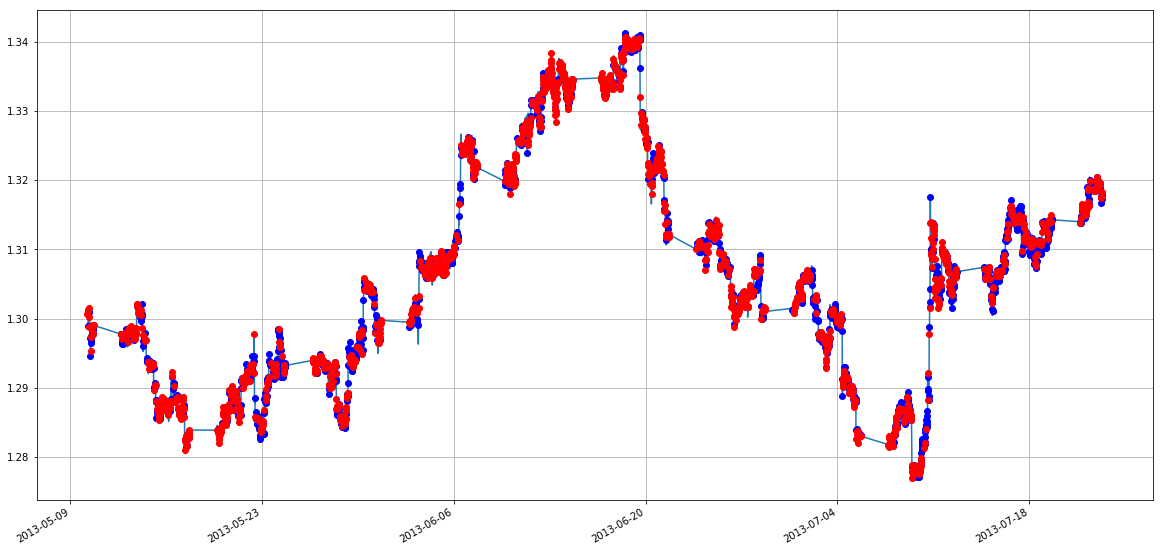

In [132]:
# plt.plot(train['Date'][15:1015], X_train['Close'])
fig, ax = plt.subplots(figsize=(20,10))

years = YearLocator()
months = MonthLocator()
yearsFmt = DateFormatter('%Y')

# ax.xaxis.set_major_locator(years)
# ax.xaxis.set_major_formatter(yearsFmt)
# ax.xaxis.set_minor_locator(months)

dates = [DT.datetime.utcfromtimestamp(timestamp).strftime('%Y-%m-%d %H:%M') for timestamp in train.iloc[5000:9999]['Timestamp']]
closes = train.iloc[5000:9999]['Close']

action = pd.DataFrame(closes.values, index=dates, columns=['Close'])
action['History'] = history[-1]
# action['Close'] = closes

ax.plot_date(dates, closes, '-')
# ax.plot_date(dates, action, '+')

ax.plot(action[action['History']==1].index, action[action['History']==1]['Close'], 'bo')
ax.plot(action[action['History']==2].index, action[action['History']==2]['Close'], 'ro')
ax.autoscale_view()
ax.grid(True)

def price(x):
    return '$%1.4f' % x

ax.fmt_xdata = DateFormatter('%Y-%m-%d')
ax.fmt_ydata = price

fig.autofmt_xdate()
# plt.xticks(rotation='vertical')
plt.show()

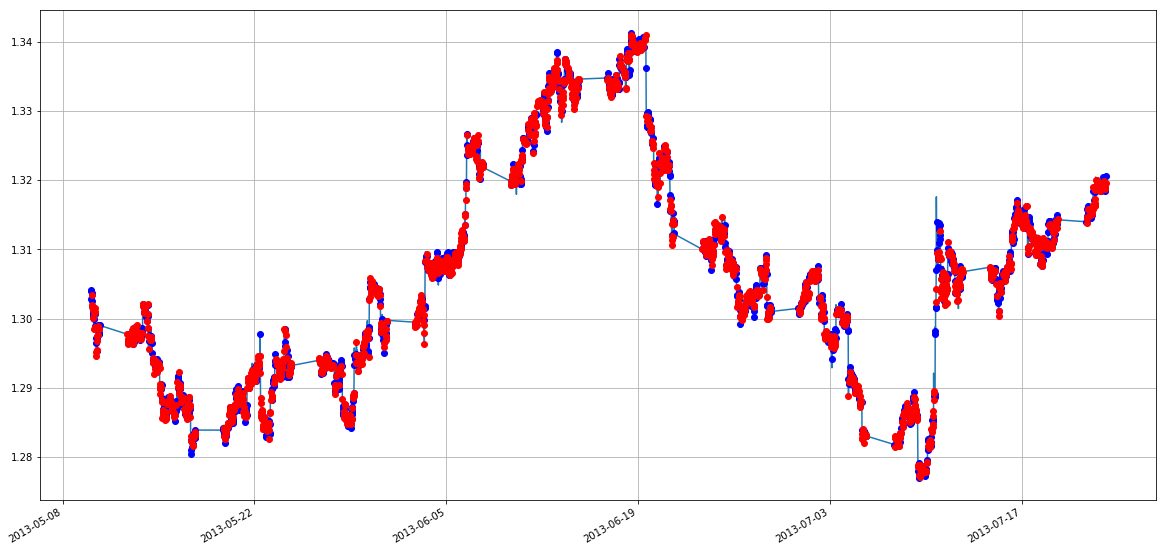

In [75]:
# plt.plot(train['Date'][15:1015], X_train['Close'])
fig, ax = plt.subplots(figsize=(20,10))

years = YearLocator()
months = MonthLocator()
yearsFmt = DateFormatter('%Y')

# ax.xaxis.set_major_locator(years)
# ax.xaxis.set_major_formatter(yearsFmt)
# ax.xaxis.set_minor_locator(months)

dates = [DT.datetime.utcfromtimestamp(timestamp).strftime('%Y-%m-%d %H:%M') for timestamp in train.iloc[5000:9999]['Timestamp']]
closes = train.iloc[5000:9999]['Close']

action = pd.DataFrame(closes.values, index=dates, columns=['Close'])
action['History'] = history[len(history) - 1]
# action['Close'] = closes

ax.plot_date(dates, closes, '-')
# ax.plot_date(dates, action, '+')

ax.plot(action[action['History']==1].index, action[action['History']==1]['Close'], 'bo')
ax.plot(action[action['History']==2].index, action[action['History']==2]['Close'], 'ro')
ax.autoscale_view()
ax.grid(True)

def price(x):
    return '$%1.4f' % x

ax.fmt_xdata = DateFormatter('%Y-%m-%d')
ax.fmt_ydata = price

fig.autofmt_xdate()
# plt.xticks(rotation='vertical')
plt.show()

In [38]:
# saver = tf.train.Saver()
# saver.save(sess, './data/sess.ckpt')

'./data/sess.ckpt'

In [62]:
oracle.save()
oracle.save_memory()
# f = open('data')
# y = pickle.load(f)
# f.close()

Saving sess to ./data/sess.ckpt
Saving memory to ./data/memory.pickle


In [86]:
def getReward(price, price_prev, action, balance, position):

    size = int(max(0, min(10000, balance/0.1)))

    reward = 0
#     balance = account['balance']    
#     position = account['position']
#     print ('price: {}, price_next: {}, position: {}'.format(price, price_next, position))
    
    if action == 1:
        if (position >= 0):
#             print ('Open Buy {}@{}'.format(size, price))            
            position += size
            reward = (price - price_prev) * position if price_prev > 0 else 0
        elif (position < 0):
#             print ('Settle Buy {}@{}, Balance: {}'.format(size, position, balance + reward))
            reward = (price - price_prev) * position if price_prev > 0 else 0
            position = 0
    elif action == 2:
        if (position <= 0):        
#             print ('Open Sell {}@{}'.format(size, price))                 
            position += size * -1            
            reward = (price - price_prev) * position if price_prev > 0 else 0
        elif (position > 0):
#             print ('Settle Sell {}@{}, Balance: {}'.format(size, position, balance + reward))                
            reward = (price - price_prev) * position if price_prev > 0 else 0
            position = 0

#     if (position != 0 and price_prev > 0):
#         reward = (price - price_prev) * position
#     else:
#         reward = 0    
    
    balance = balance + reward
    
#     return reward, balance, position
    return reward, {'balance': balance, 'position': position}